# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("./video_to_frame_and_subject.xlsx")
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/proc/id_corrected"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [4]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [5]:
def get_sleap_tracks_from_h5(filename):
    """
    Retrieve pose tracking data (tracks) from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    np.ndarray
        A transposed version of the 'tracks' dataset in the provided h5 file.
        
    Example:
    --------
    df['tracks'] = df['filename_column'].apply(get_sleap_tracks_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return f["tracks"][:].T

In [6]:
def get_sleap_track_names_from_h5(filename):
    """
    Retrieve the names of tracked features from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    h5py.Dataset
        The 'track_names' dataset in the provided h5 file, representing the names of the tracked features.
        
    Example:
    --------
    df['track_names'] = df['filename_column'].apply(get_sleap_track_names_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return [item.tobytes().decode('utf-8') for item in f["track_names"][:]]


In [129]:
def get_node_names_from_sleap(filename):
    """
    Retrieve node names from a SLEAP h5 file.

    Parameters:
    - filename (str): Path to the SLEAP h5 file.

    Returns:
    - list of str: List of node names.
    """
    with h5py.File(filename, "r") as f:
        return [n.decode() for n in f["node_names"][:]]

In [7]:

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [8]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

## Combining the h5 files between recordings

In [9]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.dropna(subset="start_frame")

In [10]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj
0,/scratch/back_up/reward_competition_extention/...,32792.0,68495.0,1.4,1.1_1.4
1,/scratch/back_up/reward_competition_extention/...,0.0,32316.0,1.1_1.4,1.1_1.4
2,/scratch/back_up/reward_competition_extention/...,32792.0,68495.0,1.1,1.1_1.4
4,/scratch/back_up/reward_competition_extention/...,32860.0,68288.0,1.2,1.1_1.2
5,/scratch/back_up/reward_competition_extention/...,2027.0,32240.0,1.1_1.2,1.1_1.2


In [11]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"].astype(int)
VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"].astype(int)

In [12]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: os.path.basename(x).split(".")[0])

In [13]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_tracks_from_h5(x))
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_track_names_from_h5(x))

In [14]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"].astype(str)

In [15]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                                [1.4]
1    [1.1, 1.4, track_867, track_868, track_869, tr...
2                                                [1.1]
4                                                [1.2]
5    [1.1, 1.2, track_16, track_18, track_40, track...
6                                                [1.1]
Name: track_names, dtype: object

In [16]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["individual_subj"].split("_")}, axis=1)

In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [18]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].apply(lambda x: {k: fill_missing(v) for k, v in x.items()})

## Looking over the tracks

In [37]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[1]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.2_subj.round_1.id_corrected.h5'

In [38]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[1], "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68495, 6, 2, 17)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [39]:
thorax_loc = locations[:, THORAX_INDEX, :, :]

In [40]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Thorax locations')

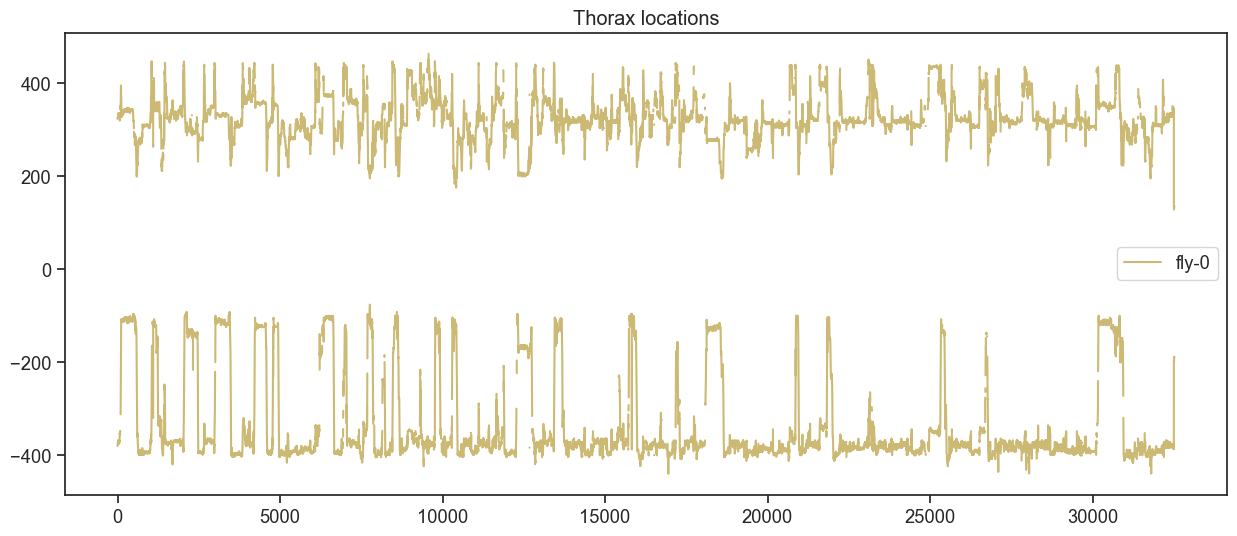

In [41]:
plt.figure()
plt.plot(thorax_loc[:,0,0], 'y',label='fly-0')

plt.plot(-1*thorax_loc[:,1,0], 'y')

plt.legend(loc="center right")
plt.title('Thorax locations')


Text(0.5, 1.0, 'Thorax tracks')

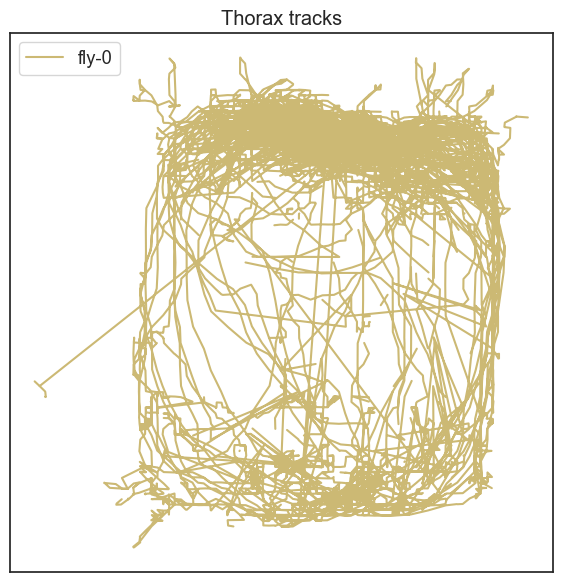

In [42]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,0],thorax_loc[:,1,0], 'y',label='fly-0')
plt.legend()

plt.xticks([])

plt.yticks([])
plt.title('Thorax tracks')

## Converting Pixels to cm

In [115]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.1_subj.round_1.id_corrected.h5'

In [122]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: "{}.fixed.corner.h5".format(x.split("fixed")[0].strip(".")))

In [123]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.corner.h5'

In [132]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_node_names_from_sleap(x))

In [133]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_bottom_right, box_bottom_le...
1    [box_top_left, box_bottom_right, box_bottom_le...
2    [box_top_left, box_bottom_right, box_bottom_le...
4    [reward_port, box_top_left, box_bottom_right, ...
5    [reward_port, box_top_left, box_bottom_right, ...
6    [reward_port, box_top_left, box_bottom_right, ...
Name: corner_parts, dtype: object

In [134]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_coordinates"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_sleap_tracks_from_h5(x))


In [146]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_coordinates"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [147]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_coordinates"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [148]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [149]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_top_left': array([210.30936449, 125.04673202]),
 'box_bottom_right': array([432.15005599, 382.61649859]),
 'box_bottom_left': array([216.44422093, 381.60537991]),
 'box_top_right': array([423.21999535, 119.91743018]),
 'reward_port': array([323.96818855, 403.40074542])}

In [151]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[5]

{'reward_port': array([340.03875718, 408.11416191]),
 'box_top_left': array([237.53817426, 128.9240927 ]),
 'box_bottom_right': array([446.61315372, 392.60730281]),
 'box_bottom_left': array([233.58147139, 389.04497809]),
 'box_top_right': array([445.61030235, 134.20980044])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [154]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"] - x["box_bottom_left"])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"] - x["box_top_left"])


In [155]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"] - x["box_top_right"])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"] - x["box_top_left"])


In [156]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [157]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = 29.5 / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = 24 / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]


In [162]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["reward_port_scaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: np.array([row["corner_to_coordinate"]["reward_port"][0] * row["width_ratio"], row["corner_to_coordinate"]["reward_port"][1] * row["height_ratio"]]), axis=1)

In [164]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["reward_port_scaled"].iloc[0]

array([[   44.59493427, -4641.39705293],
       [ 1285.31977113,    37.29022251]])

## Calculate Velocity

In [43]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].apply(lambda x: {k: v[:, THORAX_INDEX, :] for k, v in x.items()})

In [67]:
WINDOW_SIZE = 25

In [77]:
FRAME_START = 0

In [78]:
FRAME_STOP = 1000

In [85]:
file_index = 1

In [87]:
subject_id = "1.1"

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_velocities"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].apply(lambda x: {k: compute_velocity(v, window_size=WINDOW_SIZE) for k, v in x.items()})

In [68]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_velocities"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].apply(lambda x: {k: compute_velocity(v, window_size=WINDOW_SIZE) for k, v in x.items()})

In [69]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_velocities"]

0    {'1.4': [1.090861995932278, 1.010250244973919,...
1    {'1.1': [1.090861995932278, 1.010250244973919,...
2    {'1.1': [1.9522978229119398e-14, 1.91986938665...
4    {'1.2': [3.938229040789474, 3.2792710854887104...
5    {'1.1': [3.938229040789474, 3.2792710854887104...
6    {'1.1': [3.8623573184919855e-14, 3.01088512636...
Name: subject_to_thorax_velocities, dtype: object

In [70]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[0]

{'1.4': array([[324.34329224, 380.16009521],
        [324.04089355, 379.49035645],
        [324.08578491, 376.36730957],
        ...,
        [296.19107056, 391.61621094],
        [299.84280396, 388.13516235],
        [296.32232666, 387.85888672]])}

In [104]:
def smooth_diff(node_loc, win=25, poly=3, deriv=0):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=deriv)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

array([323.34959777, 323.98766277, 324.56233848, 325.08071975,
       325.54990137, 325.97697819, 326.36904501, 326.73319666,
       327.07652795, 327.40613371, 327.72910876, 328.05254792,
       328.383546  , 328.84196337, 329.31809673, 329.81458351,
       330.46772107, 331.03353935, 331.72385647, 332.12908799,
       332.61549802, 333.02144721, 333.35840924, 333.61825832,
       333.78897837, 333.86818807, 333.85274671, 333.95952499,
       334.0214726 , 334.04040647, 333.7782018 , 333.40097452,
       333.12137108, 332.82219083, 332.50293347, 332.14929537,
       332.02200348, 331.93750655, 331.74720712, 331.69566328,
       331.77825663, 331.76468855, 331.82716987, 331.95755939,
       332.15785028, 332.57956022, 332.97302273, 333.32941986,
       333.62610671, 334.06625239, 334.23025401, 334.31521267,
       334.50219182, 334.57370966, 334.54062935, 334.53996744,
       334.38156896, 334.19258071, 333.73670388, 332.8878249 ,
       331.93575234, 330.86246543, 329.6814131 , 328.66

Text(0.5, 1.0, 'Thorax locations')

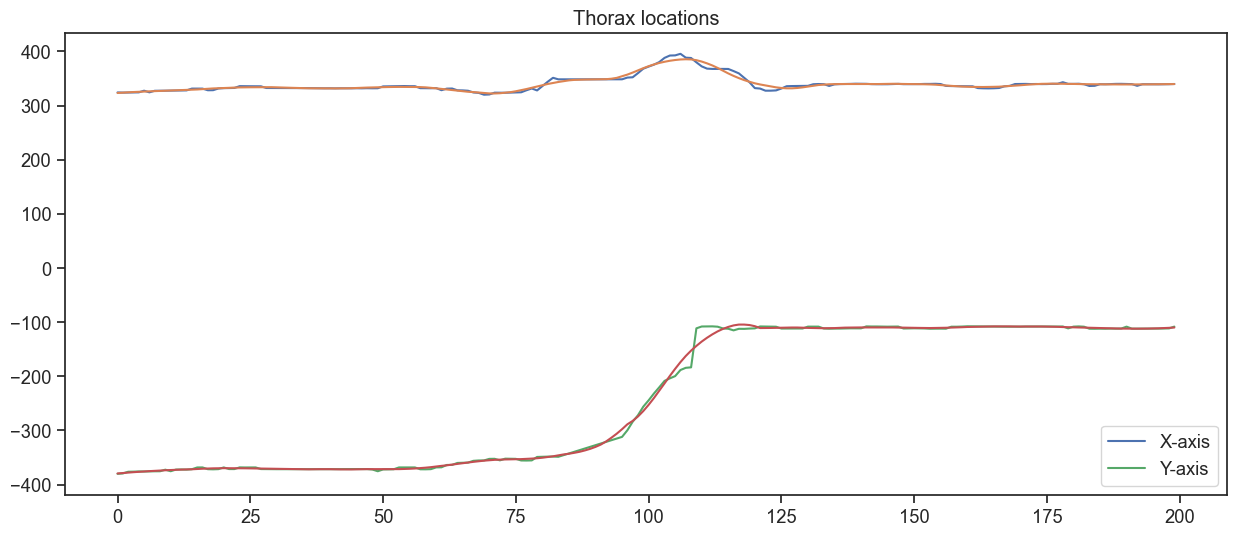

In [113]:
plt.figure()
plt.plot(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:200,0], label="X-axis")
plt.plot(savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:200,0], 25, 3, deriv=0))

plt.plot(-1*VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:200,1], label="Y-axis")
plt.plot(-1*savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:200,1], 25, 3, deriv=0))

plt.legend()
plt.title('Thorax locations')



Text(0.5, 1.0, 'Thorax locations')

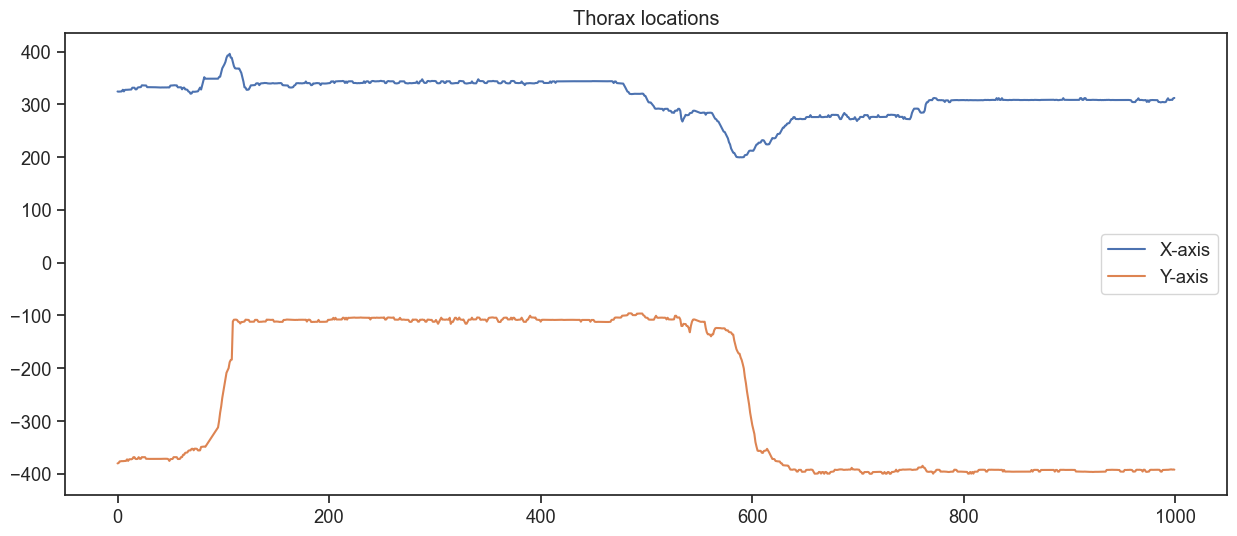

In [91]:
plt.figure()
plt.plot(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:FRAME_STOP,0], label="X-axis")

plt.plot(-1*VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:FRAME_STOP,1], label="Y-axis")
plt.legend()
plt.title('Thorax locations')

compute_velocity()

Text(0.5, 1.0, 'Thorax locations')

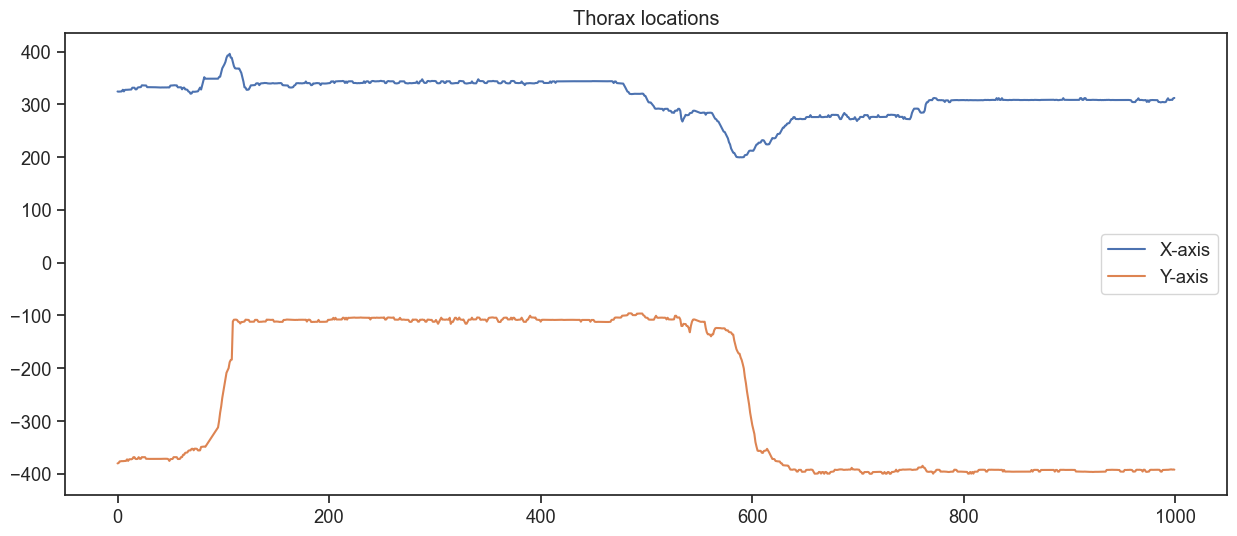

In [92]:
plt.figure()
sns.lineplot(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:FRAME_STOP,0], label="X-axis")

sns.lineplot(-1*VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].iloc[file_index][subject_id][FRAME_START:FRAME_STOP,1], label="Y-axis")
plt.legend()
plt.title('Thorax locations')


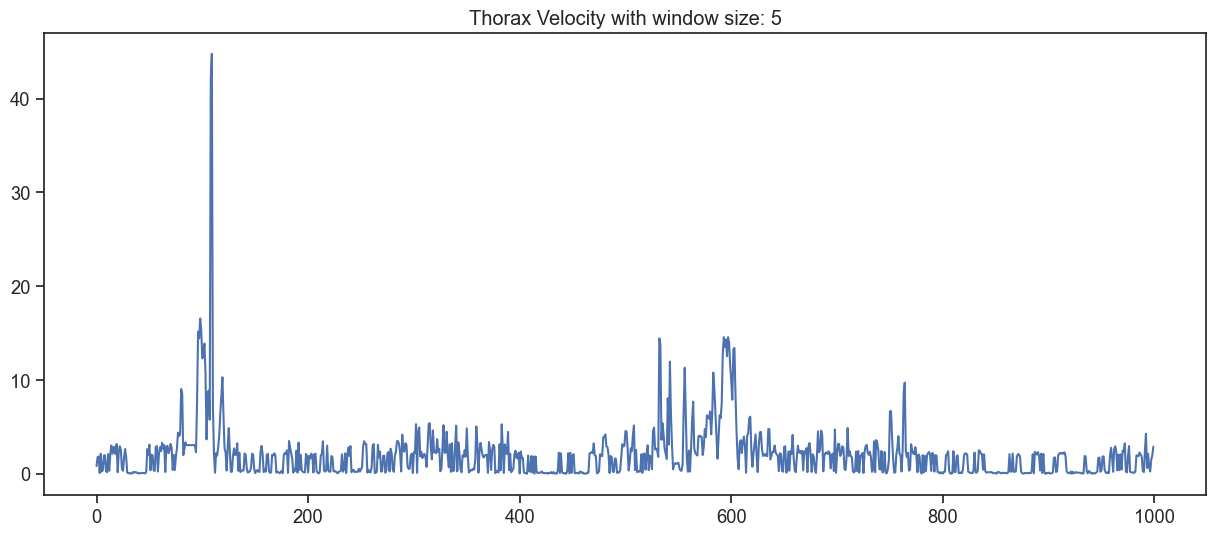

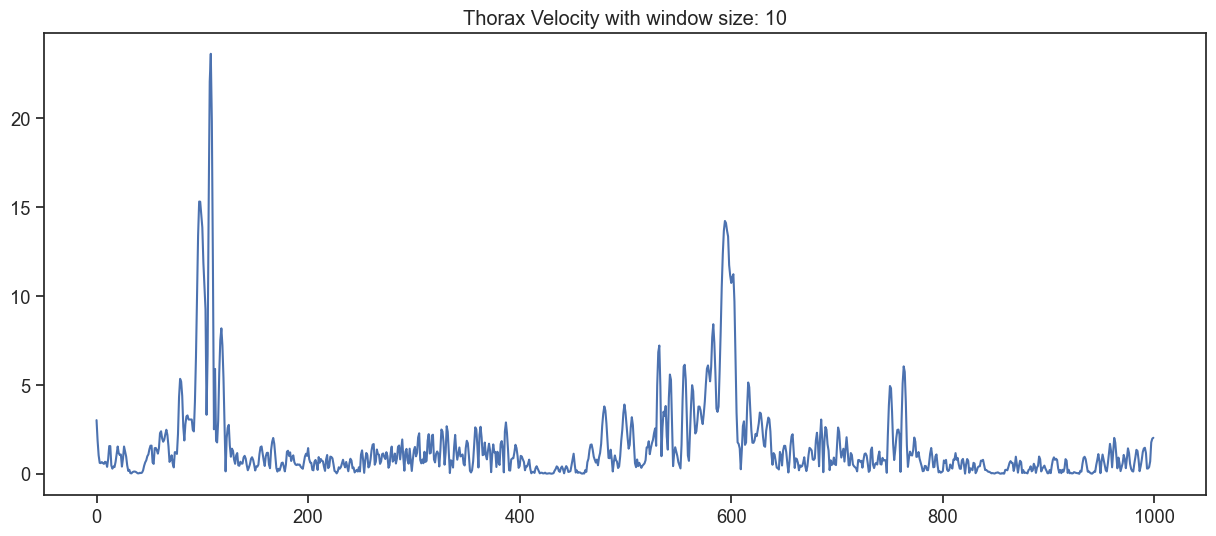

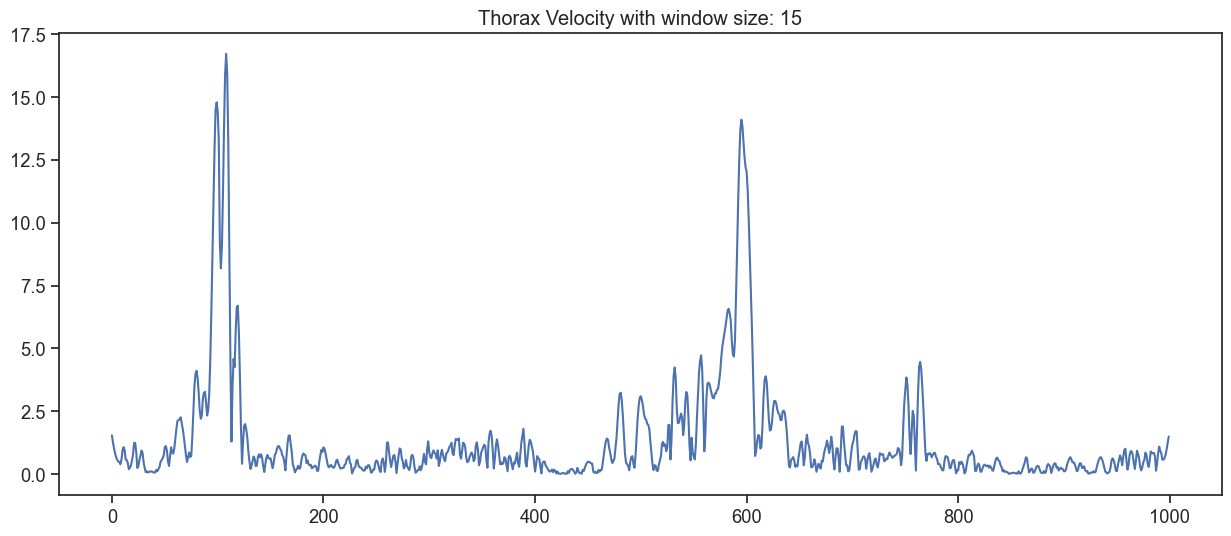

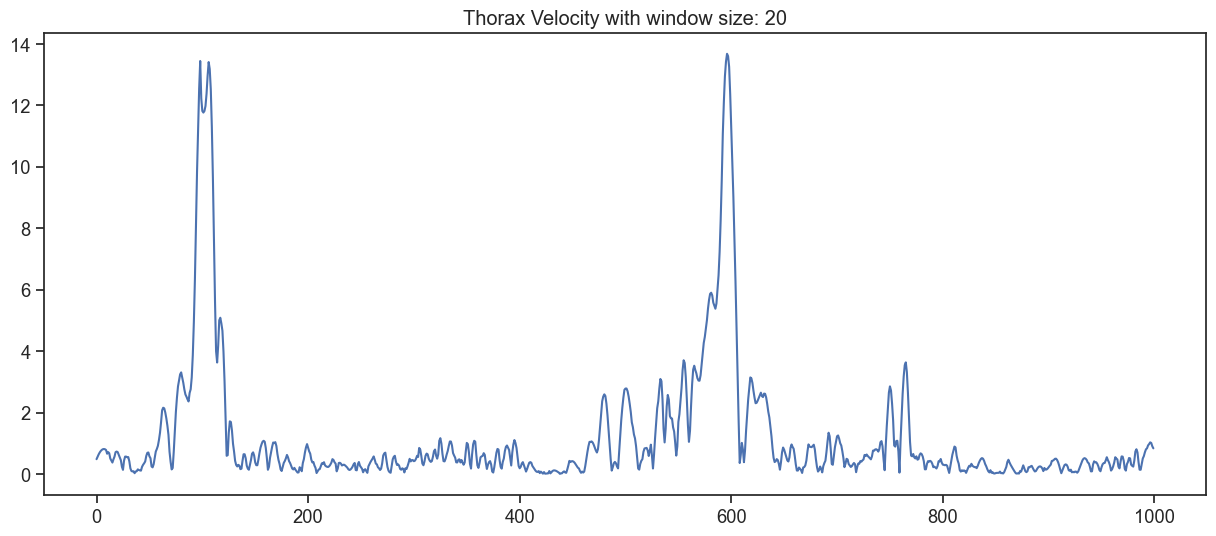

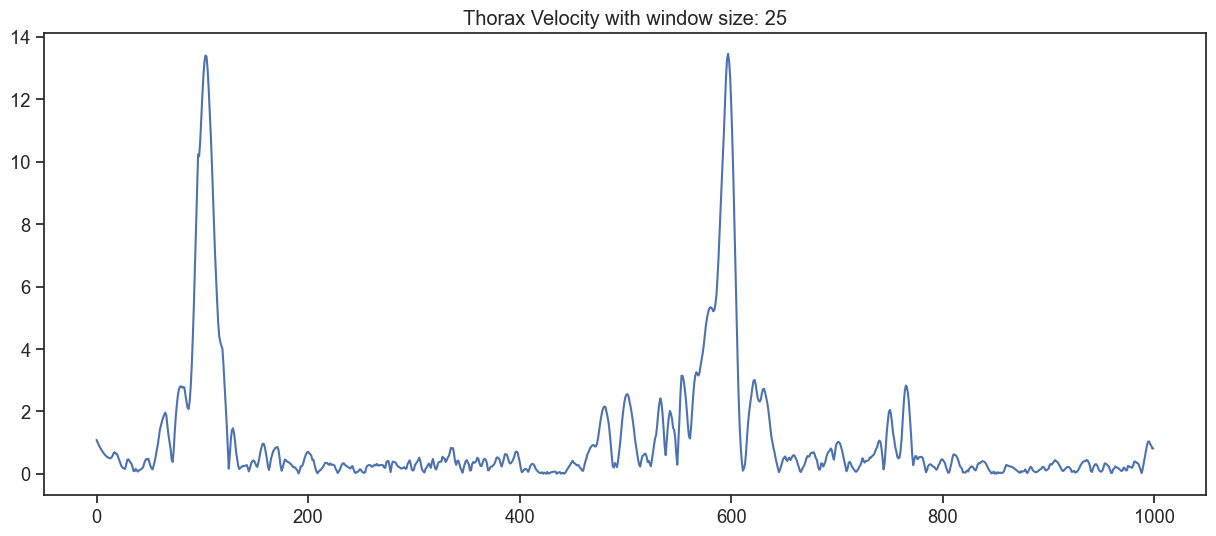

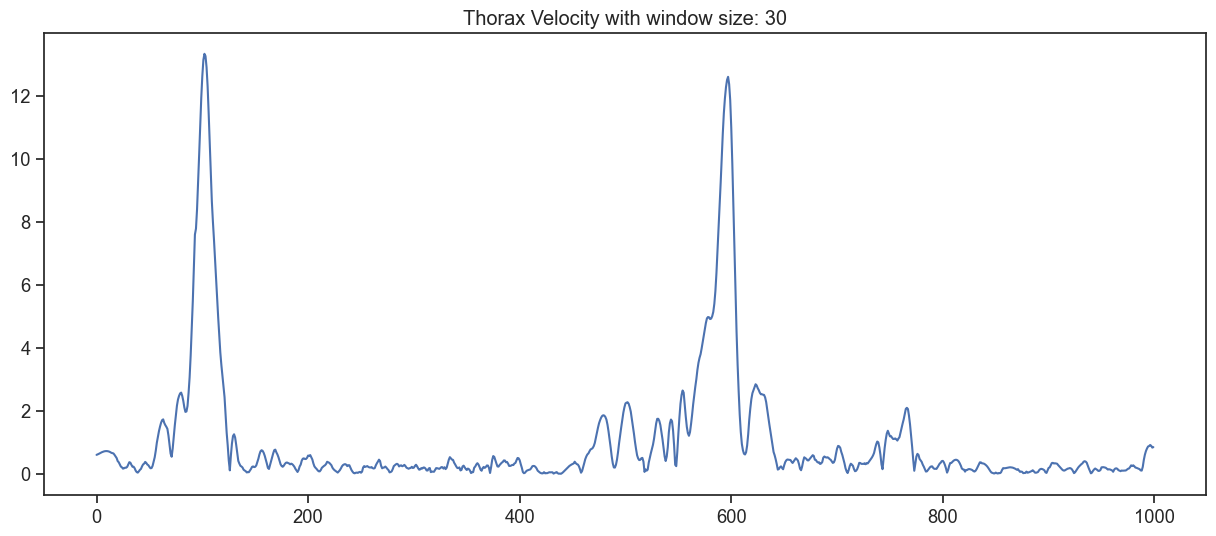

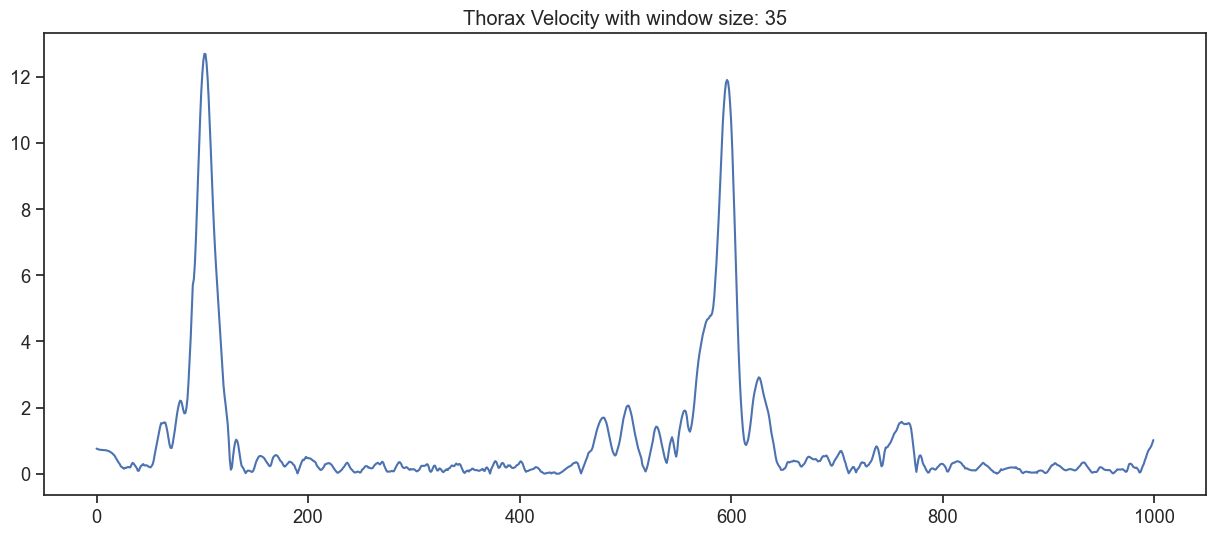

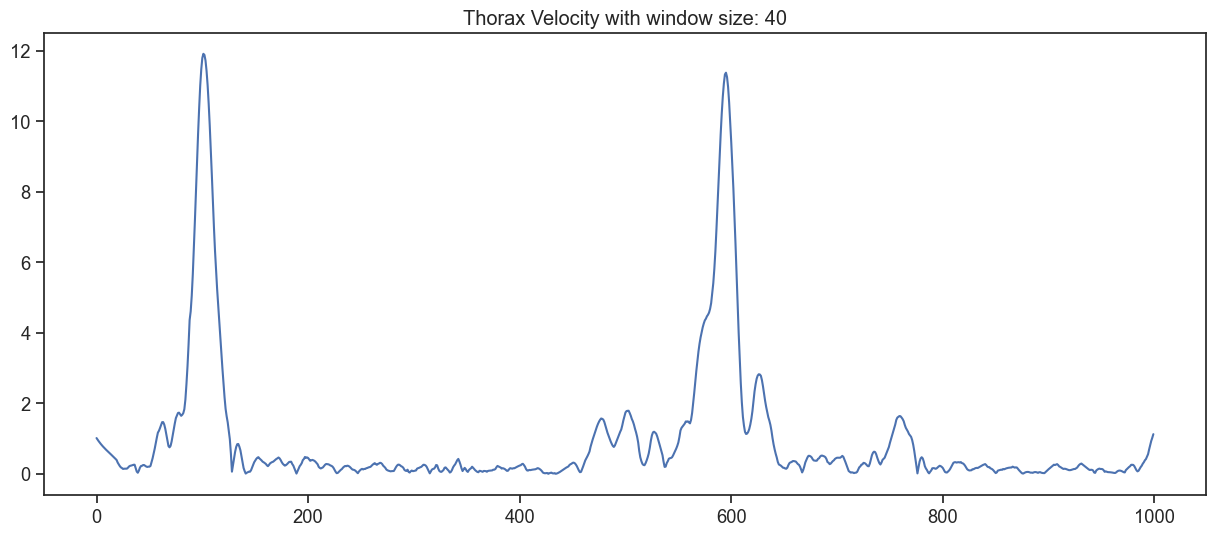

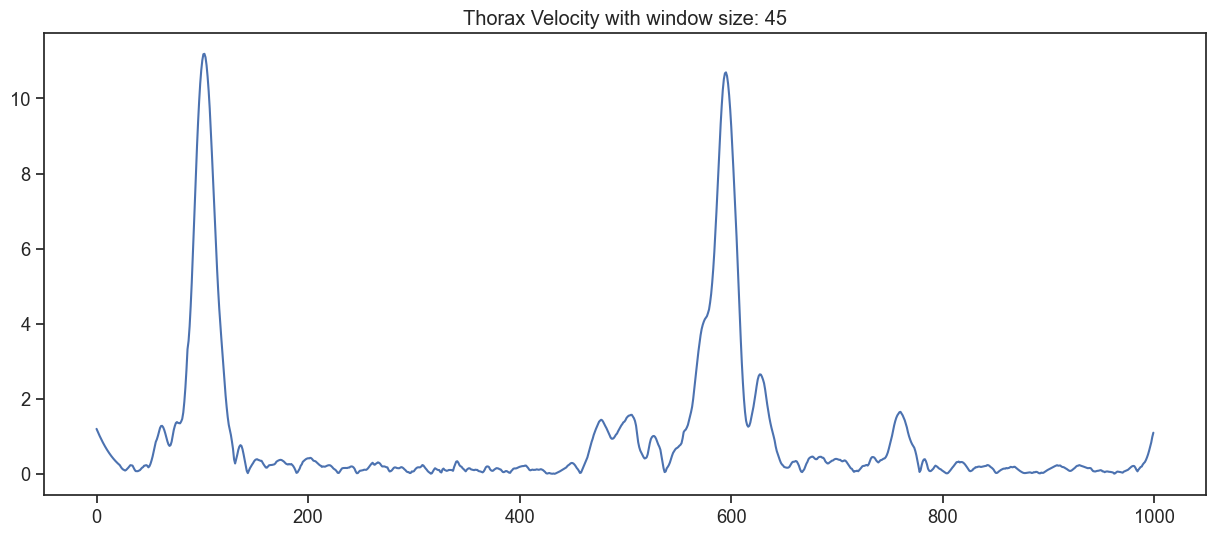

In [95]:
for num in range(5,50,5):
    VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_velocities"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_locations"].apply(lambda x: {k: compute_velocity(v, window_size=num) for k, v in x.items()})
    plt.figure()
    sns.lineplot(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_thorax_velocities"].iloc[file_index][subject_id][FRAME_START:FRAME_STOP])
    
    plt.title('Thorax Velocity with window size: {}'.format(num))
    plt.savefig("./proc/velocity_window_size_{}.png".format(num))
    plt.show()
    plt.close()

In [34]:

VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.4': [[[340.27038574 388.14276123], [324.34...
1    {'1.1': [[[340.27038574 388.14276123], [324.34...
2    {'1.1': [[[215.22697449 384.13833618], [196.90...
4    {'1.2': [[[303.96658325 368.13119507], [299.83...
5    {'1.1': [[[303.96658325 368.13119507], [299.83...
6    {'1.1': [[[187.87187195 320.01800537], [184.28...
Name: subject_to_tracks, dtype: object

In [ ]:
raise ValueError()

In [ ]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [ ]:
sorted(all_trials_df["recording_dir"].unique())

In [ ]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [ ]:
all_trials_df["recording_dir"] = all_trials_df["recording_dir"].apply(lambda x: x if "2023" in x else "subj" + "_".join(x.split("_")[-5:]))

In [ ]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: sorted([num.strip("_").replace("_",".") for num in x.replace("-", "_").split("subj")[-1].strip("_").split("and")]))

In [ ]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [ ]:
all_trials_df

In [ ]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [ ]:
all_trials_df

# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [ ]:
all_corner_h5 = glob.glob(os.path.join(SLEAP_DIR, "*/*.corner.h5"))

In [ ]:
all_pose_estimation_h5 = glob.glob(os.path.join(SLEAP_DIR, "*/*.id_corrected.h5"))

In [ ]:
len(all_corner_h5)

In [ ]:
len(all_pose_estimation_h5)

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [ ]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [ ]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [ ]:
tone_start_df["corner_file"] = tone_start_df["File Name"].map(file_name_to_corner)
tone_start_df["pose_estimation_file"] = tone_start_df["File Name"].map(file_name_to_pose_estimation)

In [ ]:
tone_start_df.head()

- Function that gets the SLEAP data

In [ ]:
def get_sleap_coordinates(filename):
    """
    """
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    return locations, node_names, track_names

In [ ]:
corner_node_names = get_sleap_coordinates(all_corner_h5[0])[1]

In [ ]:
corner_node_names

- Getting the coordinates of each corner and the reward port

In [ ]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [ ]:
tone_start_df.head()

In [ ]:
corner_columns = [col for col in tone_start_df.columns if "coordinates" in col]

In [ ]:
fig, ax = plt.subplots()

for index, row in tone_start_df.iterrows():
    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    break
plt.legend()

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [ ]:
tone_start_df["bottom_width"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
tone_start_df["top_width"] = tone_start_df.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [ ]:
tone_start_df["right_height"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
tone_start_df["left_height"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [ ]:
tone_start_df["average_height"] = tone_start_df.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
tone_start_df["average_width"] = tone_start_df.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [ ]:
tone_start_df["width_ratio"] = 29.5 / tone_start_df["average_width"]
tone_start_df["height_ratio"] = 24 / tone_start_df["average_height"]


In [ ]:
tone_start_df["reward_port_scaled"] = tone_start_df.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [ ]:
tone_start_df["reward_port_scaled"]

# Getting the coordinates of each mouse

- Function that fills missing coordinates by interpolating

In [ ]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y


In [ ]:
body_part_node_names = get_sleap_coordinates(all_pose_estimation_h5[0])[1]

In [ ]:
body_part_node_names

- Function that scales each coordinate

In [ ]:
def scale_coordinates(row, coordinate_col, height_ratio_col="height_ratio", width_ratio_col="width_ratio"):
    """
    """
    return np.dstack((row[coordinate_col][:,:,0] * row[width_ratio_col], row[coordinate_col][:,:,1] * row[height_ratio_col]))


In [ ]:
for num in range(2):
    tone_start_df["pose_estimation_subj_{}_original_coordinates".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: fill_missing(get_sleap_coordinates(x)[0][:,:,:,num]))
    tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)] = tone_start_df.apply(lambda row: scale_coordinates(row, "pose_estimation_subj_{}_original_coordinates".format(num + 1)), axis=1)     
    tone_start_df["pose_estimation_subj_{}_thorax_coordinates".format(num + 1)] = tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)].apply(lambda x: x[:,4,:])
    tone_start_df["pose_estimation_subj_{}_name".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[2][num])


In [ ]:
tone_start_df.head()

In [ ]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"].iloc[0].shape

# Calculating the distance from thorax to reward port

In [ ]:
tone_start_df["thorax_to_reward_port_distance_subj_1"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_1_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)
tone_start_df["thorax_to_reward_port_distance_subj_2"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_2_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [ ]:
frame_range = 20 * 30

In [ ]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_1"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_1"].shape[0]]), axis=1)
tone_start_df["thorax_to_reward_port_tone_slices_subj_2"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_2"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_2"].shape[0]]), axis=1)


In [ ]:
# Iterate over each row in the array
for i, row in enumerate(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[4]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')



# Averaging across trials based on strain

In [ ]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0].shape

In [ ]:
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_1"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].apply(lambda x: np.mean(x, axis=0))
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_2"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_2"].apply(lambda x: np.mean(x, axis=0))

In [ ]:
tone_start_df.head()

In [ ]:
c57_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  
c57_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  

In [ ]:
tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape

In [ ]:
np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].shape[0])  

In [ ]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#ffaf00", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#ffaf00", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#15616f", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#15616f", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Separating Rows into the two subjects

In [ ]:
tone_start_df.columns

- Getting all the columns with subject 1 or subject 2 in the name

In [ ]:
subj_1_col = [col for col in tone_start_df.columns if "subj_1" in col or "Strain" in col or "all_subj" in col or "date" in col]
subj_2_col = [col for col in tone_start_df.columns if "subj_2" in col or "Strain" in col or "all_subj" in col or "date" in col]


In [ ]:
subj_1_df = tone_start_df[subj_1_col].copy()
subj_2_df = tone_start_df[subj_2_col].copy()

- Standarizing all the columns so it's just "subj"

In [ ]:
subj_1_df.columns = [col.replace("subj_1", "subj") for col in subj_1_df.columns]
subj_2_df.columns = [col.replace("subj_2", "subj") for col in subj_2_df.columns]

In [ ]:
subj_1_df.head()

- Putting the dataframes for subject 1 and subject 2 together

In [ ]:
combined_subj_df = pd.concat([subj_1_df, subj_2_df])

In [ ]:
combined_subj_df["agent"] = combined_subj_df.apply(lambda x: list(set(x["all_subj"]) - set([x["subj"]]))[0], axis=1)

In [ ]:
combined_subj_df.head()

In [ ]:
combined_subj_df.tail()

In [ ]:
combined_subj_df.shape

In [ ]:
len(combined_subj_df["subj"].unique())

- Calculating the average distance

In [ ]:
c57_combined_subj_df = combined_subj_df[combined_subj_df["Strain"] == "C57"]
cd1_combined_subj_df = combined_subj_df[combined_subj_df["Strain"] == "CD1"]

In [ ]:
c57_combined_subj_df

In [ ]:
c57_mean_distance = np.mean(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_mean_distance = np.mean(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)

In [ ]:

cd1_std_distance = np.std(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) 
c57_std_distance = np.std(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0)

In [ ]:
len(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])

In [ ]:
len(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])

In [ ]:

cd1_sem_distance = cd1_std_distance / np.sqrt(len(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"]))  
c57_sem_distance = c57_std_distance / np.sqrt(len(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])) 

In [ ]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#15616f", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#ffaf00", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#ffaf00", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Adding the win and loss information

# Incorporating Winning and Losing

In [ ]:
reward_comp_scoring_df = pd.read_csv("./data/scoring/pilot_3_reward_competition_all_competition_cage_1_2_3_4_5_6_date_20221003_20221004.csv")

In [ ]:
reward_comp_scoring_df.columns

- Updating the date so that we can merge using it

In [ ]:
reward_comp_scoring_df["date"] = reward_comp_scoring_df["rc_date"].apply(lambda x: str(x).strip(""))

In [ ]:
reward_comp_scoring_df["date"].iloc[0]

- Updating the IDs so we can merge using it

In [ ]:
reward_comp_scoring_df["all_subj"] = reward_comp_scoring_df["rc_animal_ids"].apply(lambda x: ast.literal_eval(x))

In [ ]:
reward_comp_scoring_df["all_subj"].iloc[0]

In [ ]:
reward_comp_scoring_df["rc_winner"] = reward_comp_scoring_df["rc_winner"].apply(lambda x: ast.literal_eval(x))

In [ ]:
reward_comp_scoring_df["rc_averaged_winner"] = reward_comp_scoring_df["rc_averaged_winner"].astype(str)
reward_comp_scoring_df["rc_averaged_loser"] = reward_comp_scoring_df["rc_averaged_loser"].astype(str)

In [ ]:
for num in reward_comp_scoring_df["rc_winner"]:
    print(num)

- Merging the dataframes

In [ ]:
combined_subj_df["date"]

In [ ]:
reward_comp_scoring_df["date"]

In [ ]:
distance_and_scoring_df = combined_subj_df.merge(reward_comp_scoring_df, on=['date', 'all_subj'], how='outer')

In [ ]:
distance_and_scoring_df = distance_and_scoring_df.dropna(subset=["rc_winner", "subj"])#.dropna(subset="subj")

- Getting all the winning and losing trials based on matching IDs

In [ ]:
distance_and_scoring_df["subj"].unique()

In [ ]:
distance_and_scoring_df["per_trial_winning_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["subj"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)
distance_and_scoring_df["per_trial_losing_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["agent"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)


In [ ]:
distance_and_scoring_df["all_subj"].head()

In [ ]:
distance_and_scoring_df["rc_winner"].head()

In [ ]:
distance_and_scoring_df["per_trial_winning_indexes"].head()

In [ ]:
distance_and_scoring_df["per_trial_losing_indexes"].head()

# TODO: Check the winner vs loser ste calculations

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_winning_indexes"]], axis=1)
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_losing_indexes"]], axis=1)


In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[0].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[0].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[1].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[1].shape

- Averaging across winning and losing trials

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].apply(lambda x: np.mean(x, axis=0))
distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].apply(lambda x: np.mean(x, axis=0))

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"]

- Filtering out rows that have NANs in the average distance array

In [ ]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].apply(lambda x: np.isnan(x).any())]

In [ ]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].apply(lambda x: np.isnan(x).any())]

In [ ]:
c57_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "C57"]
cd1_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "CD1"]

In [ ]:
# Define a function to check if a NumPy array contains any NaN values
def contains_nan(arr):
    return np.isnan(arr).any()

In [ ]:
# Use the apply method to apply the function to each element in the 'A' column,
# and then use the resulting Boolean Series to select the rows where 'A' does not contain a NaN
c57_winning_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
c57_losing_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]
cd1_winning_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
cd1_losing_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]


In [ ]:
c57_winning_mean_distance = np.mean(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
c57_winning_sem_distance = np.std(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
c57_losing_mean_distance = np.mean(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
c57_losing_sem_distance = np.std(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  

cd1_winning_mean_distance = np.mean(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
cd1_winning_sem_distance = np.std(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
cd1_losing_mean_distance = np.mean(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
cd1_losing_sem_distance = np.std(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  


Colors are the website colors (Yellow #FFAF00; teal #15616F) but ive added these: light yellow: #FFDB91 (r 255 g 219 b 145) light teal: #C2DBDC  (r 194 g 219 b 220), thoughts on making all titles, axes, and numbers gray instead of black? specifically #666666 (r 96 b 96 g 96)

In [ ]:
# Add shading for the standard error
plt.plot(cd1_winning_mean_distance, color="#15616F", label="CD1 Winning Trials")
plt.fill_between(range(len(cd1_winning_mean_distance)), cd1_winning_mean_distance - cd1_winning_sem_distance, cd1_winning_mean_distance + cd1_winning_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_losing_mean_distance, color="#C2DBDC", label="CD1 Lost Trials")
plt.fill_between(range(len(cd1_losing_mean_distance)), cd1_losing_mean_distance - cd1_losing_sem_distance, cd1_losing_mean_distance + cd1_losing_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_losing_mean_distance, color="#FFDB91", label="C57 Lost Trials")
plt.fill_between(range(len(c57_losing_mean_distance)), c57_losing_mean_distance - c57_losing_sem_distance, c57_losing_mean_distance + c57_losing_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winning_mean_distance, color="#FFAF00", label="C57 Winning Trials")
plt.fill_between(range(len(c57_winning_mean_distance)), c57_winning_mean_distance - c57_winning_sem_distance, c57_winning_mean_distance + c57_winning_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

# Separating by overall winner and loser

In [ ]:
no_tie_distance_and_scoring_df = distance_and_scoring_df[~distance_and_scoring_df["rc_is_win_to_win_and_loss_ratio_tie"]]

In [ ]:
no_tie_distance_and_scoring_df["is_winner"] = no_tie_distance_and_scoring_df["subj"] == no_tie_distance_and_scoring_df["rc_averaged_winner"]

In [ ]:
c57_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & (no_tie_distance_and_scoring_df["is_winner"])]
c57_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & ~(no_tie_distance_and_scoring_df["is_winner"])]

cd1_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & (no_tie_distance_and_scoring_df["is_winner"])]
cd1_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & ~(no_tie_distance_and_scoring_df["is_winner"])]

In [ ]:
c57_winner_mean_distance = np.mean(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_winner_sem_distance = np.std(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
c57_loser_mean_distance = np.mean(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_loser_sem_distance = np.std(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  

cd1_winner_mean_distance = np.mean(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_winner_sem_distance = np.std(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
cd1_loser_mean_distance = np.mean(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_loser_sem_distance = np.std(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  


In [ ]:
import seaborn as sns

In [ ]:
# Add shading for the standard error
plt.plot(cd1_winner_mean_distance, color="#15616F", label="CD1 Overall Winner")
plt.fill_between(range(len(cd1_winner_mean_distance)), cd1_winner_mean_distance - cd1_winner_sem_distance, cd1_winner_mean_distance + cd1_winner_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_loser_mean_distance, color="#C2DBDC", label="CD1 Overall Loser")
plt.fill_between(range(len(cd1_loser_mean_distance)), cd1_loser_mean_distance - cd1_loser_sem_distance, cd1_loser_mean_distance + cd1_loser_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_loser_mean_distance, color="#FFDB91", label="C57 Overall Loser")
plt.fill_between(range(len(c57_loser_mean_distance)), c57_loser_mean_distance - c57_loser_sem_distance, c57_loser_mean_distance + c57_loser_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winner_mean_distance, color="#FFAF00", label="C57 Overall Winner")
plt.fill_between(range(len(c57_winner_mean_distance)), c57_winner_mean_distance - c57_winner_sem_distance, c57_winner_mean_distance + c57_winner_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

In [ ]:
sns.histplot(distance_and_scoring_df[distance_and_scoring_df["strain"] == "C57"]["rc_tie_count"], alpha=0.5, color="#FFAF00", binwidth=1, label="C57")
sns.histplot(distance_and_scoring_df[distance_and_scoring_df["strain"] == "CD1"]["rc_tie_count"], alpha=0.5, color="#15616F", binwidth=1, label="CD1")
plt.title("C57 have more ties")
plt.xlabel("Number of ties")
plt.legend()

In [ ]:
distance_and_scoring_df[distance_and_scoring_df["strain"] == "C57"]["rc_tie_count"]

In [ ]:
distance_and_scoring_df[distance_and_scoring_df["strain"] == "CD1"]["rc_tie_count"]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>